In [1]:
import pandas as pd
import numpy as np
from support_functions import log_progress, clean_drugbank, query_chembl
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import functools
from cmapPy.pandasGEXpress import parse
import scipy
import multiprocessing
from joblib import Parallel, delayed

/Users/Nico/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Cleaning LINCS data

We have a lot of LINCS gene expression data to work with, both from compound (cpd) treatment experiments and gene knockdown (KD) experiments. There's a high degree of redundancy (duplicate experiments) and heterogenaity (experiments run in different cell lines), which we will have to deal with. 
<br>
Ultimately, what we want is a list of cpd-KD pairs,  where for each pair we know:
1. if the cpd-gene pair represents a true/known interaction (1), or a false one (0)
2. the cpd and KD have high-quality expression signatures in at least three COMMON cell lines
3. the KD gene has interaction partners with high-quality KD signatures down in the SAME cell lines

___
# 1. Load the data

In [18]:
# LINCS Phase 1 data
pert_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_pert_info.txt', sep='\t', header=0)
pert_metrics_1 = pd.read_csv('data/GSE92742_Broad_LINCS_pert_metrics.txt', sep='\t', header=0)
sig_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_sig_info.txt', sep='\t', header=0, dtype={'pert_dose': float})
sig_metrics_1 = pd.read_csv('data/GSE92742_Broad_LINCS_sig_metrics.txt', sep='\t', header=0)
gene_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)

# LINCS Phase 2 data
pert_info_2a = pd.read_csv('data/GSE70138_Broad_LINCS_pert_info.txt', sep='\t', header=0)
sig_info_2 = pd.read_csv('data/GSE70138_Broad_LINCS_sig_info_2017-03-06.txt', sep='\t', header=0, dtype={'pert_dose': float})
sig_metrics_2 = pd.read_csv('data/GSE70138_Broad_LINCS_sig_metrics_2017-03-06.txt', sep='\t', header=0)

# Combine Phase 1 and Phase 2 data
pert_info = pd.concat([pert_info_1, pert_info_2a], ignore_index=True).reset_index(drop=True)
sig_info = pd.concat([sig_info_1, sig_info_2], ignore_index=True).reset_index(drop=True)
sig_metrics = pd.concat([sig_metrics_1, sig_metrics_2], ignore_index=True).reset_index(drop=True)

# For convenience, combine the sig_info and sig_metrics tables
sig_info = pd.concat([sig_info, sig_metrics[['distil_cc_q75', 'pct_self_rank_q25', 'tas']]], axis=1)

___
# 2. Remove low-quality signatures

In [20]:
# Data quality parameters 
pct_self_rank_cutoff = 0.05
distill_cc_cutoff = 0.2

# Filter the data
hi_q_idx = sig_info[(sig_info.distil_cc_q75 >= distill_cc_cutoff) &
                    (sig_info.pct_self_rank_q25 <= pct_self_rank_cutoff)].index
hi_q_sig_info = sig_info.loc[hi_q_idx]
hi_q_cpd_sig_info = hi_q_sig_info[hi_q_sig_info.pert_type == 'trt_cp']
hi_q_kd_sig_info = hi_q_sig_info[hi_q_sig_info.pert_type == 'trt_sh']

# Create reference lists of hi-quality cpds and KDS
hi_q_cpds = set(hi_q_cpd_sig_info.pert_id.unique()) # n = 4488
hi_q_kds = set(hi_q_kd_sig_info.pert_iname.unique()) # n = 4344

# Save these lists for reference
pickle.dump(hi_q_cpds, open('checkpoint_files/hi_q_cpds.sav', 'wb'))
pickle.dump(hi_q_kds, open('checkpoint_files/hi_q_kds.sav', 'wb'))

In [2]:
hi_q_cpds = pickle.load(open('checkpoint_files/hi_q_cpds.sav', 'rb'))
hi_q_kds = pickle.load(open('checkpoint_files/hi_q_kds.sav', 'rb'))

# 3. Select representative signatures

Some cpds & KDs have multiple high-quality signatures from the same cell line. So we'll use only those signatures with the highest transcriptional activity score (TAS) in those cell lines.

In [148]:
# Select representative cpd sigs
repr_cpd_sig_info_dict = {}
for cpd in log_progress(hi_q_cpds):
    high_q_cpd_sigs = hi_q_cpd_sig_info[hi_q_cpd_sig_info.pert_id == cpd]
    repr_cpd_sigs_df = pd.DataFrame(columns=high_q_cpd_sigs.columns)
    for cell_line in high_q_cpd_sigs.cell_id.unique():
        candidate_sigs = high_q_cpd_sigs[high_q_cpd_sigs.cell_id == cell_line]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()].copy()
        repr_cpd_sigs_df = repr_cpd_sigs_df.append(repr_sig)
    repr_cpd_sig_info_dict[cpd] = repr_cpd_sigs_df

# Select representative KD sigs
repr_kd_sig_info_dict = {}
for kd in log_progress(hi_q_kds):
    high_q_kd_sigs = hi_q_kd_sig_info[hi_q_kd_sig_info.pert_iname == kd]
    repr_kd_sigs_df = pd.DataFrame(columns=high_q_kd_sigs.columns)
    for cell_line in high_q_kd_sigs.cell_id.unique():
        candidate_sigs = high_q_kd_sigs[high_q_kd_sigs.cell_id == cell_line]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()].copy()
        repr_kd_sigs_df = repr_kd_sigs_df.append(repr_sig)
    repr_kd_sig_info_dict[kd] = repr_kd_sigs_df

# Save the data
pickle.dump(repr_cpd_sig_info_dict, open('checkpoint_files/repr_cpd_sig_info_dict.sav', 'wb'))
pickle.dump(repr_kd_sig_info_dict, open('checkpoint_files/repr_kd_sig_info_dict.sav', 'wb'))

In [15]:
# Load representative sigs
repr_cpd_sig_info_dict = pickle.load(open('checkpoint_files/repr_cpd_sig_info_dict.sav', 'rb'))
repr_kd_sig_info_dict = pickle.load(open('checkpoint_files/repr_kd_sig_info_dict.sav', 'rb'))

___
# 4. Generate cpd-KD pairs (pair_set_1)

In [91]:
# Load targets extracted from Drugbank and Chembl
drugbank_target_dict = pickle.load(open('checkpoint_files/drugbank_target_dict.sav', 'rb'))
chembl_target_dict = pickle.load(open('checkpoint_files/chembl_target_dict.sav', 'rb'))

# Lookup pert_id <-> inchi_key mappings
cpd_pert_info = pert_info[pert_info.pert_type == 'trt_cp']
cpd_inchis = cpd_pert_info[['pert_id', 'inchi_key']]

# Combine Drugbank and Chembl dicts, using pert_id for keys
LINCS_target_dict = {}

for inchi, targets in log_progress(drugbank_target_dict.items()):
    cpd = cpd_inchis[cpd_inchis.inchi_key == inchi].pert_id.values
    if cpd.size > 0: 
        cpd = cpd[0]
        LINCS_target_dict[cpd] = set(targets)

for inchi, targets in log_progress(chembl_target_dict.items()):
    cpd = cpd_inchis[cpd_inchis.inchi_key == inchi].pert_id.values
    if cpd.size > 0: 
        cpd = cpd[0]
        if cpd in LINCS_target_dict.keys():
            all_targets = LINCS_target_dict[cpd].union(set(targets))
            LINCS_target_dict[cpd] = all_targets
        else:
            LINCS_target_dict[cpd] = set(targets)

# Save the LINCS target dictionary            
filename = 'checkpoint_files/LINCS_target_dict.sav'
pickle.dump(LINCS_target_dict, open(filename, 'wb'))

In [125]:
# Create dataframe for hi-quality cpd-kd pairs
# label=1 if the pair is a known interaction, label=0 otherwise
LINCS_target_dict = pickle.load(open('checkpoint_files/LINCS_target_dict.sav', 'rb'))

cpd_ = []
kd_ = []
label_ = []
for cpd in log_progress(hi_q_cpds, every=1):
    try: cpd_targets = LINCS_target_dict[cpd]
    except KeyError: cpd_targets = set()
    for kd in hi_q_kds:
        if kd in cpd_targets: label = 1
        else: label = 0
        cpd_.append(cpd)
        kd_.append(kd)
        label_.append(label)
        
pair_set_1_df = pd.DataFrame({'cpd': cpd_, 'kd': kd_, 'label': label_,})
pair_set_1_df.to_csv('checkpoint_files/pair_set_1_df.csv')

In [4]:
pair_set_1_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_1_df.csv')
print('Pair set 1 statistics\n')
print('No. True interactions:\t', pair_set_1_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_1_df[pair_set_1_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_1_df[pair_set_1_df.label == 1].kd.unique()))
print('\nNo. False interactions:\t', pair_set_1_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_1_df[pair_set_1_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_1_df[pair_set_1_df.label == 0].kd.unique()))

Pair set 1 statistics

No. True interactions:	 1981
No. True cpds:		 687
No. True genes:		 506

No. False interactions:	 19493891
No. False cpds:		 4488
No. False genes:	 4344


___
# 4. Filter out pairs without at least n=3 common cell experiments (pair_set_2)

Some of our cpd-kd pairs do not have experimental data from the same cell lines, and thus we can't use them.

In [163]:
# Make dictionary of cpd cell lines for fast lookup
repr_cpd_cell_line_dict = {}
for cpd, repr_sig_df in log_progress(repr_cpd_sig_info_dict.items()):
    cells = set(repr_sig_df.cell_id)
    repr_cpd_cell_line_dict[cpd] = cells
    
# Make dictionary of KD cell lines for fast lookup
repr_kd_cell_line_dict = {}
for kd, repr_sig_df in log_progress(repr_kd_sig_info_dict.items()):
    cells = set(repr_sig_df.cell_id)
    repr_kd_cell_line_dict[kd] = cells
    
# Save to disk
pickle.dump(repr_cpd_cell_line_dict, open('checkpoint_files/repr_cpd_cell_line_dict.sav', 'wb'))
pickle.dump(repr_kd_cell_line_dict, open('checkpoint_files/repr_kd_cell_line_dict.sav', 'wb'))

In [3]:
# Load cell line dicts
repr_cpd_cell_line_dict = pickle.load(open('checkpoint_files/repr_cpd_cell_line_dict.sav', 'rb'))
repr_kd_cell_line_dict = pickle.load(open('checkpoint_files/repr_kd_cell_line_dict.sav', 'rb'))

In [18]:
# The minimum number of common cells we will require
min_num_common_cells = 3

This filtering step takes a while so we're going to run it in parallel:

In [5]:
def filter_2(pair_set_1_subdf):
    
    # Filter pairs from pair_set_1
    cpd_2_, target_2_, label_2_, common_cells_2_ = [], [], [], []
    for index, row in log_progress(pair_set_1_subdf.iterrows(), every=10000):

        # Placekeeper to prevent repeat lookups
        curr_cpd = ''
        curr_cpd_cells = ''

        # Lookup cpd sigs, if necessary
        cpd = row.cpd
        if not cpd == curr_cpd:
            curr_cpd = cpd   
            curr_cpd_cells = repr_cpd_cell_line_dict[cpd]

        # Lookup KD sigs
        kd = row.kd
        kd_cells = repr_kd_cell_line_dict[kd]

        # Compare cell lines
        common_cells = curr_cpd_cells & kd_cells
        if len(common_cells) >= min_num_common_cells:
            cpd_2_.append(cpd)
            target_2_.append(kd)
            label_2_.append(row.label)
            common_cells_2_.append(common_cells)
        
    # Compile & return filtered data
    pair_set_2_subdf = pd.DataFrame({'cpd': cpd_2_, 'kd': target_2_, 'label': label_2_})
    return pair_set_2_subdf, common_cells_2_

In [ ]:
# Split up the pairs for parallel filtering
num_processes = multiprocessing.cpu_count()
chunk_size = int(pair_set_1_df.shape[0]/num_processes)
pair_set_1_subdfs = [ pair_set_1_df.iloc[pair_set_1_df.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pair_set_1_df.shape[0], chunk_size)]

# Filter each chunk of the pairs dataframe in parallel
results = Parallel(n_jobs=num_processes, backend="multiprocessing")(
             map(delayed(filter_2), pair_set_1_subdfs))

# Compile and pair_set_2
pair_set_2_subdfs = [ r[0] for r in results ]
pair_set_2_df = functools.reduce(lambda x,y: x.append(y), pair_set_2_subdfs).reset_index(drop=True)

# Compile and common_cells_2_
common_cells_2_sublists = [ r[1] for r in results ]
common_cells_2_ = functools.reduce(lambda x,y: x+y, common_cells_2_sublists)

In [76]:
# Save results to disk
pair_set_2_df.to_csv('checkpoint_files/pair_set_2_df.csv')
pickle.dump(common_cells_2_, open('checkpoint_files/common_cells_2_.sav', 'wb'))

In [5]:
# Reload pair_set_2
pair_set_2_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_2_df.csv')
common_cells_2_ = pickle.load(open('checkpoint_files/common_cells_2_.sav', 'rb'))

In [6]:
# Rename 'target' column to 'kd'
pair_set_2_df = pair_set_2_df.rename(index=str, columns={"target": "kd"})

In [7]:
print('Pair set 2 statistics\n')
print('No. True interactions:\t', pair_set_2_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_2_df[pair_set_2_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_2_df[pair_set_2_df.label == 1].kd.unique()))
print('\nNo. False interactions:\t', pair_set_2_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_2_df[pair_set_2_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_2_df[pair_set_2_df.label == 0].kd.unique()))

Pair set 2 statistics

No. True interactions:	 757
No. True cpds:		 230
No. True genes:		 310

No. False interactions:	 4119311
No. False cpds:		 1228
No. False genes:	 3876


___
# 5. Filter out pairs without interaction partner KDs in at least n=3 cell lines (pair_set_3)

In [8]:
# Load the STRING 4.0 protein interaction dictionary
string_interactions_dict = pickle.load(open('checkpoint_files/string_interactions_dict.sav', 'rb'))
string_genes = set(string_interactions_dict.keys())

This step is also quite slow, so we'll run in parallel. We also won't keep track of which partners are in each cell line, because requires too much memory.

In [9]:
def filter_3(chunk):
    pair_set_2_subdf, common_cells_2_sublist = chunk
    
    # Filter pairs from pair_set_2
    cpd_3_, target_3_, label_3_, common_cells_3_, common_partners_3_ = [], [], [], [], []
    
    for index, row in log_progress(pair_set_2_subdf.iterrows(), every=10000):
        # Check if there are interaction partners
        kd = row.kd
        if kd in string_genes:
            partners = string_interactions_dict[kd]

            # Check if partners have high-quality KDS in the pair's common_cells
            hi_q_partners = partners.intersection(hi_q_kds)   
            if len(hi_q_partners) > 0:
                common_partners_dict = {}
                common_cells = common_cells_2_sublist[index]
                for cell_line in common_cells:
                    cell_partners = set([ p for p in hi_q_partners if cell_line in repr_kd_cell_line_dict[p]])
                    if len(cell_partners) > 0:
                        common_partners_dict[cell_line] = cell_partners
            
                
                # Store resutls if we have high-quality partner KDS in at least 3 common_cells
                common_partner_cells = set(common_partners_dict.keys())
                if len(common_partner_cells) >= min_num_common_cells:
                    cpd_3_.append(row.cpd)
                    target_3_.append(kd)
                    label_3_.append(row.label)
                    common_cells_3_.append(common_partner_cells)
                    common_partners_3_.append(common_partners_dict)

    # Compile & return filtered data
    pair_set_3_subdf = pd.DataFrame({'cpd': cpd_3_, 'kd': target_3_, 'label': label_3_})
    return pair_set_3_subdf, common_cells_3_, common_partners_3_

In [5]:
# Paralellization parameters
num_batches = 20
num_processes = multiprocessing.cpu_count()

In [10]:
# Batch the data
batch_size = int(pair_set_2_df.shape[0]/num_batches)
pair_set_2_batches = [ pair_set_2_df.iloc[pair_set_2_df.index[i:i + batch_size]].reset_index(drop=True) for i in range(0, pair_set_2_df.shape[0], batch_size)]
common_cells_2_batches = [ common_cells_2_[i:i + batch_size] for i in range(0, len(common_cells_2_), batch_size) ]

for b in log_progress(range(num_batches)):
    pair_set_2_batch = pair_set_2_batches[b]
    common_cells_2_batch = common_cells_2_batches[b]

    # Split up the batches for parallel filtering
    chunk_size = int(pair_set_2_batch.shape[0]/num_processes)

    pair_set_2_subdfs = [ pair_set_2_batch.iloc[pair_set_2_batch.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pair_set_2_batch.shape[0], chunk_size)]
    common_cells_2_sublists = [ common_cells_2_batch[i:i + chunk_size] for i in range(0, len(common_cells_2_batch), chunk_size) ]
    chunks = list(zip(pair_set_2_subdfs, common_cells_2_sublists))

    # Filter each chunk of the pairs dataframe in parallel
    results = Parallel(n_jobs=num_processes, backend="multiprocessing")(
                 map(delayed(filter_3), chunks))

    # Compile results
    pair_set_3_subdfs = [ r[0] for r in results ]
    pair_set_3_subdf = functools.reduce(lambda x,y: x.append(y), pair_set_3_subdfs).reset_index(drop=True)
    common_cells_3_sublists = [ r[1] for r in results ]
    common_cells_3_sublist = functools.reduce(lambda x,y: x+y, common_cells_3_sublists)
    common_partners_3_sublists = [ r[2] for r in results ]
    common_partners_3_sublist = functools.reduce(lambda x,y: x+y, common_partners_3_sublists)
    
    # Save results
    pair_set_3_subdf.to_csv('checkpoint_files/pair_set_3_subdf_{}.csv'.format(b))
    pickle.dump(common_cells_3_sublist, open('checkpoint_files/common_cells_3_sublist_{}.sav'.format(b), 'wb'))
    pickle.dump(common_partners_3_sublist, open('checkpoint_files/common_partners_3_sublist_{}.sav'.format(b), 'wb'))
    
    # Clear memory
    results = None 
    pair_set_3_subdfs, pair_set_3_subdf = None, None
    common_cells_3_sublists, common_cells_3_sublist = None, None
    common_partners_3_sublists, common_partners_3_sublist = None, None

In [10]:
# Load filtered pairs 
pair_set_3_df = pd.DataFrame(columns=['cpd', 'kd', 'label'])

for b in log_progress(range(num_batches)):
    df_filename = 'checkpoint_files/pair_set_3_subdf_{}.csv'.format(b)
    pair_set_3_df = pair_set_3_df.append(pd.DataFrame.from_csv(df_filename))

In [7]:
print('Pair set 3 statistics\n')
print('No. True interactions:\t', pair_set_3_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_3_df[pair_set_3_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_3_df[pair_set_3_df.label == 1].kd.unique()))
print('\nNo. False interactions:\t', pair_set_3_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_3_df[pair_set_3_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_3_df[pair_set_3_df.label == 0].kd.unique()))

Pair set 3 statistics

No. True interactions:	 746
No. True cpds:		 230
No. True genes:		 302

No. False interactions:	 3481166
No. False cpds:		 1228
No. False genes:	 3288


# 6. Filter out pairs not in the n=7 most common cell lines (pair_set_4)

Some cell lines have a very small number of true interactions that we can learn from. So for now we'll only focus on the common cell lines.

In [8]:
# Load the common cell data
common_cells_3_ = []
for b in log_progress(range(num_batches)):
    cc_filename = 'checkpoint_files/common_cells_3_sublist_{}.sav'.format(b)
    common_cells_3_ += pickle.load(open(cc_filename, 'rb'))

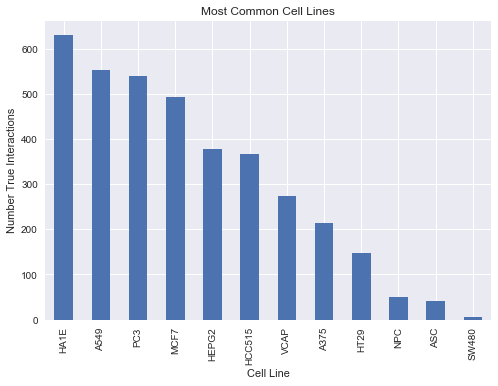

In [11]:
# Which cells are the most common for True interactions?
true_pair_idx = pair_set_3_df[pair_set_3_df.label == 1].index.values.astype(int)
true_pair_common_cells = np.array(common_cells_3_)[true_pair_idx]
all_cell_list = np.array(functools.reduce( lambda x,y: x+y, [ list(s) for s in true_pair_common_cells ] ))
cell_line_counts = pd.Series(all_cell_list).value_counts()
cell_line_counts.plot.bar()
plt.xlabel('Cell Line')
plt.ylabel('Number True Interactions')
plt.title('Most Common Cell Lines')
plt.show()

In [13]:
top_7_cell_lines = set(cell_line_counts.index[:7])
common_cells_3_ = None
pair_set_3_df = None
true_pair_common_cells = None
all_cell_list = None

In [38]:
def filter_4(chunk):
    pair_set_3_subdf, common_partners_3_sublist = chunk
    
    # Filter pairs from pair_set_3
    cpd_4_, target_4_, label_4_, common_cells_4_, common_partners_4_ = [], [], [], [], []
    
    for index, row in log_progress(pair_set_3_subdf.iterrows(), every=5000):
        common_partners_dict = common_partners_3_sublist[index]
        common_cells = set(common_partners_dict.keys())
        top_common_cells = top_7_cell_lines & common_cells
        
        # Remove the pair if it doesn't have at least 3 top-7 cells
        if len(top_common_cells) >= min_num_common_cells:
            top_common_partners_dict = {}
            for cell_line in top_common_cells:
                top_common_partners_dict[cell_line] = common_partners_dict[cell_line]
            
            cpd_4_.append(row.cpd)
            target_4_.append(row.kd)
            label_4_.append(row.label)
            common_cells_4_.append(top_common_cells)
            common_partners_4_.append(top_common_partners_dict)
            
    # Compile & return filtered data
    pair_set_4_subdf = pd.DataFrame({'cpd': cpd_4_, 'kd': target_4_, 'label': label_4_})
    return pair_set_4_subdf, common_cells_4_, common_partners_4_

In [39]:
# Filter out pairs not in the 7 most common cell lines
for b in log_progress(range(num_batches)):
    pair_set_3_batch = pd.DataFrame.from_csv('checkpoint_files/pair_set_3_subdf_{}.csv'.format(b))
    common_partners_3_batch = pickle.load(open('checkpoint_files/common_partners_3_sublist_{}.sav'.format(b), 'rb'))

    # Split up the batches for parallel filtering
    chunk_size = int(pair_set_3_batch.shape[0]/num_processes)
    pair_set_3_subdfs = [ pair_set_3_batch.iloc[pair_set_3_batch.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pair_set_3_batch.shape[0], chunk_size)]
    common_partners_3_sublists = [ common_partners_3_batch[i:i + chunk_size] for i in range(0, len(common_partners_3_batch), chunk_size) ]
    chunks = list(zip(pair_set_3_subdfs, common_partners_3_sublists))

    # Filter each chunk of the pairs dataframe in parallel
    results = Parallel(n_jobs=num_processes, backend="multiprocessing")(
                 map(delayed(filter_4), chunks))
    
    # Compile results
    pair_set_4_subdfs = [ r[0] for r in results ]
    pair_set_4_subdf = functools.reduce(lambda x,y: x.append(y), pair_set_4_subdfs).reset_index(drop=True)
    common_cells_4_sublists = [ r[1] for r in results ]
    common_cells_4_sublist = functools.reduce(lambda x,y: x+y, common_cells_4_sublists)
    common_partners_4_sublists = [ r[2] for r in results ]
    common_partners_4_sublist = functools.reduce(lambda x,y: x+y, common_partners_4_sublists)
    
    # Save results
    pair_set_4_subdf.to_csv('checkpoint_files/pair_set_4_subdf_{}.csv'.format(b))
    pickle.dump(common_cells_4_sublist, open('checkpoint_files/common_cells_4_sublist_{}.sav'.format(b), 'wb'))
    pickle.dump(common_partners_4_sublist, open('checkpoint_files/common_partners_4_sublist_{}.sav'.format(b), 'wb'))
    
    # Clear memory
    results = None 
    pair_set_4_subdfs, pair_set_4_subdf = None, None
    common_cells_4_sublists, common_cells_4_sublist = None, None
    common_partners_4_sublists, common_partners_4_sublist = None, None

In [43]:
# Load filtered pairs 
pair_set_4_df = pd.DataFrame(columns=['cpd', 'kd', 'label'])
common_cells_4_ = []

for b in log_progress(range(num_batches)):
    df_filename = 'checkpoint_files/pair_set_4_subdf_{}.csv'.format(b)
    pair_set_4_df = pair_set_3_df.append(pd.DataFrame.from_csv(df_filename))
    cc_filename = 'checkpoint_files/common_cells_4_sublist_{}.sav'.format(b)
    common_cells_4_ += pickle.load(open(cc_filename, 'rb'))

In [42]:
print('Pair set 4 statistics\n')
print('No. True interactions:\t', pair_set_4_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_4_df[pair_set_4_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_4_df[pair_set_4_df.label == 1].kd.unique()))
print('\nNo. False interactions:\t', pair_set_4_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_4_df[pair_set_4_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_4_df[pair_set_4_df.label == 0].kd.unique()))

Pair set 4 statistics

No. True interactions:	 770
No. True cpds:		 230
No. True genes:		 302

No. False interactions:	 3536440
No. False cpds:		 1228
No. False genes:	 3288


___
# 7. Extract gene expression signatures

In [45]:
# Load gene info
gene_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)
lm_genes = gene_info_1[gene_info_1['pr_is_lm'].astype(bool)]
lm_gene_ids = lm_genes['pr_gene_id'].astype(str).values

In [52]:
# Pull repr cpd sigs from the top 7 cell lines
repr_top_7_cpd_sigs = pd.DataFrame()
for pert_id in log_progress(pair_set_4_df.cpd.unique()):
    repr_cpd_sigs = repr_cpd_sig_info_dict[pert_id]
    repr_cpd_sigs = repr_cpd_sigs[repr_cpd_sigs.cell_id.isin(top_7_cell_lines)]
    repr_top_7_cpd_sigs = repr_top_7_cpd_sigs.append(repr_cpd_sigs)
repr_top_7_cpd_sigs = repr_top_7_cpd_sigs.reset_index(drop=True)

In [53]:
# Pull all repr kd sigs from the top 7 cell lines
repr_top_7_kd_sigs = pd.DataFrame()
for pert_iname, repr_kd_sigs in log_progress(repr_kd_sig_info_dict.items()):
    repr_kd_sigs = repr_kd_sigs[repr_kd_sigs.cell_id.isin(top_7_cell_lines)]
    repr_top_7_kd_sigs = repr_top_7_kd_sigs.append(repr_kd_sigs)
repr_top_7_kd_sigs = repr_top_7_kd_sigs.reset_index(drop=True)

In [55]:
# Extract the actual cpd signatures
phase_1_sig_ids = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', col_meta_only=True).index.values
phase_2_sig_ids = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', col_meta_only=True).index.values

# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_7_cpd_sig_ids = [ str(s.encode('UTF8')) for s  in repr_top_7_cpd_sigs.sig_id.values ]
phase_1_top_7_cpd_sig_ids = [ s for s in top_7_cpd_sig_ids if s in phase_1_sig_ids ]
phase_2_top_7_cpd_sig_ids = [ s for s in top_7_cpd_sig_ids if s in phase_2_sig_ids ]

# extract the actual signatures
phase_1_top_7_cpd_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=phase_1_top_7_cpd_sig_ids).data_df
phase_2_top_7_cpd_sigs = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', cid=phase_2_top_7_cpd_sig_ids).data_df
phase_2_top_7_cpd_sigs.rename(lambda x: x[2:-1], inplace=True)
top_7_cpd_raw_sigs = pd.concat([phase_1_top_7_cpd_sigs, phase_2_top_7_cpd_sigs], axis=1)

# discard all but landmark gene values
top_7_cpd_lm_sigs = top_7_cpd_raw_sigs[top_7_cpd_raw_sigs.index.isin(lm_gene_ids)].sort_index().copy()

# reformat the sig_ids so they are nice strings
top_7_cpd_lm_sigs = top_7_cpd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
top_7_cpd_lm_sigs.head()

cid,CPC005_A549_6H:BRD-K49294207-300-01-2:10,CPC005_A549_6H:BRD-K84895041-001-01-6:10,CPC005_A549_6H:BRD-A55484088-050-01-7:10,CPC005_A549_6H:BRD-A22713669-001-01-9:10,CPC005_A549_6H:BRD-A56020723-001-02-0:10,CPC005_A549_6H:BRD-K56429665-001-03-9:10,CPC005_A549_6H:BRD-A76941896-003-02-0:10,CPC005_A549_6H:BRD-K64755930-003-02-4:10,CPC005_A549_6H:BRD-K09778810-001-01-5:10,CPC005_A549_6H:BRD-K59332007-300-01-9:10,...,LJP009_PC3_24H:H01,LPROT001_MCF7_6H:K01,LPROT001_PC3_6H:H18,LPROT001_PC3_6H:P02,LPROT002_A549_6H:O03,LPROT002_MCF7_6H:J18,LPROT002_MCF7_6H:L04,REP.A026_HA1E_24H:A16,REP.A026_HA1E_24H:C04,REP.A026_HA1E_24H:D10
10007,6.973750,-1.002187,5.968729,-0.953470,0.562095,-0.713414,1.394778,0.379642,-0.639863,-0.572912,...,2.392944,-0.9115,-3.5535,-0.8313,0.1721,0.6884,0.2987,0.615736,-1.413066,-0.405487
1001,-0.267279,-0.456261,-0.437818,0.090598,-0.857233,-0.721990,2.196101,-0.227097,0.447476,-0.509215,...,3.227689,-0.5532,-0.1200,1.2937,0.2178,-4.9659,0.3805,-0.211431,-0.251532,-0.510453
10013,1.237686,0.733325,-1.591386,-0.317255,0.293296,-0.578746,1.685715,-0.181047,0.212449,-1.277575,...,-0.112838,-0.8921,-3.4834,0.6745,0.1847,-0.9694,0.8371,-0.443996,-0.620000,-0.234399
10038,0.063985,-1.620348,-1.702004,-0.494152,0.296358,0.145910,-7.275051,0.300573,-0.119113,-0.664986,...,-0.194425,2.0580,1.0855,0.1106,0.5542,0.0294,0.6745,0.451793,-4.528064,0.206856
10046,-0.499549,0.326133,1.083981,-0.502755,0.305382,0.605420,5.107271,-0.725981,-0.396668,-0.738087,...,0.446669,1.1517,-1.2228,0.0974,-3.1562,0.2901,1.0849,-0.472678,-0.683095,-0.123612


In [56]:
print(repr_top_7_cpd_sigs.shape)
print(top_7_cpd_lm_sigs.shape)
repr_top_7_cpd_sigs.to_csv('checkpoint_files/repr_top_7_cpd_sigs.csv')
top_7_cpd_lm_sigs.to_csv('checkpoint_files/top_7_cpd_lm_sigs.csv')

(4838, 15)
(978, 4838)


In [57]:
# Extract the actual KD signatures
# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_7_kd_sig_ids = [ str(s.encode('UTF8')) for s in repr_top_7_kd_sigs.sig_id.values ]

# read in the data
top_7_kd_raw_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=top_7_kd_sig_ids).data_df

# discard non-landmark gene expression scores
top_7_kd_lm_sigs = top_7_kd_raw_sigs[top_7_kd_raw_sigs.index.isin(lm_gene_ids)].sort_index().copy()

# reformat the sig_ids so they are nice strings
top_7_kd_lm_sigs = top_7_kd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
top_7_kd_lm_sigs.head()

cid,DER001_A549_96H:TRCN0000052584:-666,DER001_A549_96H:TRCN0000231931:-666,DER001_A549_96H:TRCN0000338771:-666,DER001_A549_96H:TRCN0000230574:-666,DER001_A549_96H:TRCN0000369366:-666,DER001_A549_96H:TRCN0000138966:-666,DER001_A549_96H:TRCN0000195610:-666,DER001_A549_96H:TRCN0000139625:-666,DER001_A549_96H:TRCN0000196714:-666,DER001_A549_96H:TRCN0000051206:-666,...,KDB001_PC3_96H:TRCN0000343797:-666,KDB001_PC3_96H:TRCN0000319318:-666,KDB001_PC3_96H:TRCN0000323290:-666,KDB001_PC3_96H:TRCN0000159391:-666,KDB001_PC3_96H:TRCN0000364667:-666,KDB001_PC3_96H:TRCN0000135504:-666,KDB001_PC3_96H:TRCN0000142389:-666,KDB001_PC3_96H:TRCN0000180510:-666,KDB001_PC3_96H:TRCN0000254328:-666,KDB001_PC3_96H:TRCN0000133950:-666
rid,,,,,,,,,,,,,,,,,,,,,
10007,0.238107,-0.622791,-2.890380,0.289155,0.230212,-0.534408,-0.701051,-1.529376,-1.596325,-1.50570,...,-0.39430,0.39255,0.40935,1.98080,0.46525,-0.81515,-0.31605,-0.02665,0.36655,1.32305
1001,-0.742594,0.320136,1.582691,1.116215,1.036991,-0.027469,2.398777,-0.195812,1.224051,1.99940,...,0.75325,-0.32005,-1.70935,0.82750,0.14065,-0.61405,-0.14040,0.64610,1.46140,0.01925
10013,0.469476,-0.401893,-1.417432,-1.239244,-0.584913,-1.086684,-1.116879,-0.879018,-0.243091,-1.81925,...,-0.43025,-0.46250,-0.24895,0.34875,-0.56190,0.47240,-0.57825,-0.82385,0.35615,0.69620
10038,0.945602,-0.939611,-0.307037,0.454981,-0.786091,0.521690,-0.964038,-0.762941,0.188488,-0.23265,...,-0.14960,-0.22880,0.61105,-2.17760,0.02495,0.22810,-1.60735,0.69330,-0.59275,-0.38195
10046,-0.641048,0.229374,0.584793,-0.233250,0.137667,4.069284,0.324046,0.608330,1.061105,1.52550,...,-0.15285,-0.22195,-0.83325,0.00205,-1.43080,0.42020,-0.35985,0.94590,-0.75705,0.32970


In [60]:
print(repr_top_7_kd_sigs.shape)
print(top_7_kd_lm_sigs.shape)
repr_top_7_kd_sigs.to_csv('checkpoint_files/repr_top_7_kd_sigs.csv')
top_7_kd_lm_sigs.to_csv('checkpoint_files/top_7_kd_lm_sigs.csv')

(23660, 15)
(978, 23660)


___
# 8. Calculate direct correlation features

In [2]:
# Load the signature data
repr_top_7_cpd_sigs = pd.DataFrame.from_csv('checkpoint_files/repr_top_7_cpd_sigs.csv')
top_7_cpd_lm_sigs = pd.DataFrame.from_csv('checkpoint_files/top_7_cpd_lm_sigs.csv')
repr_top_7_kd_sigs = pd.DataFrame.from_csv('checkpoint_files/repr_top_7_kd_sigs.csv')
top_7_kd_lm_sigs = pd.DataFrame.from_csv('checkpoint_files/top_7_kd_lm_sigs.csv')

In [62]:
def compute_dir_corr(chunk):
    pair_subset, cell_subset = chunk
    
    # Initialize empty dataframe to hold direct correlation values
    dir_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_7_cell_lines)

    # Loop through cpd-target pairs, calculate correlations in each cell line
    for index, row in log_progress(pair_subset.iterrows(), every=1000):
        
        cpd = row.cpd
        cpd_sig_info = repr_cpd_sig_info_dict[cpd]
        kd = row.kd
        kd_sig_info = repr_kd_sig_info_dict[kd]
        
        for cell_line in cell_subset[index]:
            cpd_cell_sig_info = cpd_sig_info[cpd_sig_info.cell_id == cell_line]
            kd_cell_sig_info = kd_sig_info[kd_sig_info.cell_id == cell_line]

            # extract signatures
            cpd_sig_id = cpd_cell_sig_info.sig_id
            kd_sig_id = kd_cell_sig_info.sig_id
            cpd_lm_sig = top_7_cpd_lm_sigs[cpd_sig_id].values
            kd_lm_sig = top_7_kd_lm_sigs[kd_sig_id].values
            #compute and store correlation
            corr = scipy.stats.pearsonr(cpd_lm_sig, kd_lm_sig)[0][0]
            dir_corr_df.at[index, cell_line] = corr
    
    return dir_corr_df

In [63]:
# Compute correlations in parallel
for b in log_progress(range(num_batches)):
    # Load the batch
    df_filename = 'checkpoint_files/pair_set_4_subdf_{}.csv'.format(b)
    cc_filename = 'checkpoint_files/common_cells_4_sublist_{}.sav'.format(b)
    pair_subset = pd.DataFrame.from_csv(df_filename)
    cell_subset = pickle.load(open(cc_filename, 'rb'))
    
    # Split the batch into chunks
    chunk_size = int(pair_subset.shape[0]/num_processes)
    pair_chunks = [ pair_subset.iloc[pair_subset.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pair_subset.shape[0], chunk_size)]
    cell_chunks = [ cell_subset[i:i + chunk_size] for i in range(0, len(cell_subset), chunk_size) ]
    chunks = list(zip(pair_chunks, cell_chunks))

    # Compute correlations in parallel
    results = Parallel(n_jobs=num_processes, backend="multiprocessing")(
                 map(delayed(compute_dir_corr), chunks))
    
    # Compile and save data
    dir_corr_sub_df = functools.reduce(lambda x,y: pd.concat([x,y]), results)
    filename = 'features/top_7_dir_corr_sub_df_{}.csv'.format(b)
    dir_corr_sub_df.to_csv(filename)

___
# 9. Calculate indirect correlation features

In [3]:
def compute_indir_corr(chunk):
    pair_subset, partner_subset = chunk

    # initialize empty dataframe to hold indirect correlation values
    indir_max_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_7_cell_lines)
    indir_min_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_7_cell_lines)
    indir_avg_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_7_cell_lines)

    # Loop through cpd-target pairs, calculate correlations in each cell line
    for index, row in log_progress(pair_subset.iterrows(), every=100):        
        cpd = row.cpd
        partner_dict = partner_subset[index]
        
        # Compute cpd correlations w/ each partner in each cell line 
        cpd_sig_info = repr_cpd_sig_info_dict[cpd]
        for cell_line in partner_dict.keys():
            
            # Extract cell-specific cpd sig
            cpd_sig_id = cpd_sig_info[cpd_sig_info.cell_id == cell_line].sig_id
            cpd_lm_sig = top_7_cpd_lm_sigs[cpd_sig_id].values

            # Compute cell-specific partner corrs
            cell_partners = partner_dict[cell_line]
            pkd_corrs = pd.Series(index=cell_partners)
            for partner in cell_partners:
                pkd_sig_info = repr_kd_sig_info_dict[partner]
                pkd_sig_id = pkd_sig_info[pkd_sig_info.cell_id == cell_line].sig_id
                pkd_lm_sig = top_7_kd_lm_sigs[pkd_sig_id].values
                
                # compute and store correlations
                corr = scipy.stats.pearsonr(cpd_lm_sig, pkd_lm_sig)[0][0]
                pkd_corrs[partner] = corr

            # compute correlation statistics
            max_pkd_corr = pkd_corrs.max()
            min_pkd_corr = pkd_corrs.min()
            avg_pkd_corr = pkd_corrs.mean()

            # store these in the appropriate data frames
            indir_max_corr_df.at[index, cell_line] = max_pkd_corr
            indir_min_corr_df.at[index, cell_line] = min_pkd_corr
            indir_avg_corr_df.at[index, cell_line] = avg_pkd_corr
            
    return indir_max_corr_df, indir_min_corr_df, indir_avg_corr_df

In [ ]:
# Compute batch correlations in parallel
start_batch = 16
for b in log_progress(range(start_batch, num_batches)):
    df_filename = 'checkpoint_files/pair_set_4_subdf_{}.csv'.format(b)
    cp_filename = 'checkpoint_files/common_partners_4_sublist_{}.sav'.format(b)
    pair_subset = pd.DataFrame.from_csv(df_filename)
    partner_subset = pickle.load(open(cp_filename, 'rb'))
    
    # Split data into chunks
    chunk_size = int(pair_subset.shape[0]/num_processes)
    pair_chunks = [ pair_subset.iloc[pair_subset.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pair_subset.shape[0], chunk_size)]
    partner_chunks = [ partner_subset[i:i + chunk_size] for i in range(0, len(partner_subset), chunk_size) ]
    chunks = list(zip(pair_chunks, partner_chunks))

    # Compute indirect correlations for each chunk in parallel
    results = Parallel(n_jobs=num_processes, backend="multiprocessing")(
                 map(delayed(compute_indir_corr), chunks))

    # Collect results
    max_dfs, min_dfs, avg_dfs = zip(*results)
    indir_max_corr_df = functools.reduce(lambda x,y: pd.concat([x,y]), max_dfs)
    indir_min_corr_df = functools.reduce(lambda x,y: pd.concat([x,y]), min_dfs)
    indir_avg_corr_df = functools.reduce(lambda x,y: pd.concat([x,y]), avg_dfs)

    # Save to disk
    max_df_filename = 'features/top_7_indir_max_corr_sub_df_{}.csv'.format(b)
    min_df_filename = 'features/top_7_indir_min_corr_sub_df_{}.csv'.format(b)
    avg_df_filename = 'features/top_7_indir_avg_corr_sub_df_{}.csv'.format(b)
    indir_max_corr_df.to_csv(max_df_filename)
    indir_min_corr_df.to_csv(min_df_filename)
    indir_avg_corr_df.to_csv(avg_df_filename)
    
    # Clear  memory
    results, max_dfs, min_dfs, avg_dfs = None, None, None, None
    indir_max_corr_df, indir_min_corr_df, indir_avg_corr_df = None, None, None

In [65]:
l = [(1,2,3),(4,5,6),(7,8,9)]

In [67]:
max_dfs, min_dfs, avg_dfs = zip(*l)

In [70]:
functools.reduce(lambda x,y: x+y, min_dfs)

15